In [1]:
import os, sys, time, glob, random, argparse
import numpy as np
from copy import deepcopy
import torch
import torch.nn as nn

# XAutoDL 
from xautodl.config_utils import load_config, dict2config, configure2str
from xautodl.datasets import get_datasets, get_nas_search_loaders
from xautodl.procedures import (
    prepare_seed,
    prepare_logger,
    save_checkpoint,
    copy_checkpoint,
    get_optim_scheduler,
)
from xautodl.utils import get_model_infos, obtain_accuracy
from xautodl.log_utils import AverageMeter, time_string, convert_secs2time
from xautodl.models import get_search_spaces

from custom_models import get_cell_based_tiny_net
from custom_search_cells import NAS201SearchCell as SearchCell
from xautodl.models.cell_searchs.genotypes import Structure

# NB201
from nas_201_api import NASBench201API as API

import scipy.stats as stats

2022-11-01 05:38:09.918745: I tensorflow/core/util/util.cc:169] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.


In [2]:
parser = argparse.ArgumentParser("Random search for NAS.")
parser.add_argument("--data_path", type=str, default='../cifar.python', help="The path to dataset")
parser.add_argument("--dataset", type=str, default='cifar10',choices=["cifar10", "cifar100", "ImageNet16-120"], help="Choose between Cifar10/100 and ImageNet-16.")

# channels and number-of-cells
parser.add_argument("--search_space_name", type=str, default='nas-bench-201', help="The search space name.")
parser.add_argument("--config_path", type=str, default='./MY.config', help="The path to the configuration.")
parser.add_argument("--max_nodes", type=int, default=4, help="The maximum number of nodes.")
parser.add_argument("--channel", type=int, default=16, help="The number of channels.")
parser.add_argument("--num_cells", type=int, default=5, help="The number of cells in one stage.")
parser.add_argument("--select_num", type=int, default=100, help="The number of selected architectures to evaluate.")
parser.add_argument("--track_running_stats", type=int, default=0, choices=[0, 1], help="Whether use track_running_stats or not in the BN layer.")
# log
parser.add_argument("--workers", type=int, default=4, help="number of data loading workers")
parser.add_argument("--save_dir", type=str, default='./include_none-loop2-2_ep2-reset_classifier', help="Folder to save checkpoints and log.")
# parser.add_argument("--arch_nas_dataset", type=str, default='../NAS-Bench-201-v1_1-096897.pth', help="The path to load the architecture dataset (tiny-nas-benchmark).")
parser.add_argument("--arch_nas_dataset", type=str, default=None, help="The path to load the architecture dataset (tiny-nas-benchmark).")
parser.add_argument("--print_freq", type=int, default=200, help="print frequency (default: 200)")
parser.add_argument("--rand_seed", type=int, default=None, help="manual seed")
args = parser.parse_args(args=[])
if args.rand_seed is None or args.rand_seed < 0:
    args.rand_seed = random.randint(1, 100000)

    
print(args.rand_seed)
print(args)
xargs=args

28723
Namespace(arch_nas_dataset=None, channel=16, config_path='./MY.config', data_path='../cifar.python', dataset='cifar10', max_nodes=4, num_cells=5, print_freq=200, rand_seed=28723, save_dir='./include_none-loop2-2_ep2-reset_classifier', search_space_name='nas-bench-201', select_num=100, track_running_stats=0, workers=4)


In [3]:
assert torch.cuda.is_available(), "CUDA is not available."
torch.backends.cudnn.enabled = True
torch.backends.cudnn.benchmark = False
torch.backends.cudnn.deterministic = True
torch.set_num_threads(xargs.workers)
prepare_seed(xargs.rand_seed)
logger = prepare_logger(args)

Main Function with logger : Logger(dir=include_none-loop2-2_ep2-reset_classifier, use-tf=False, writer=None)
Arguments : -------------------------------
arch_nas_dataset : None
channel          : 16
config_path      : ./MY.config
data_path        : ../cifar.python
dataset          : cifar10
max_nodes        : 4
num_cells        : 5
print_freq       : 200
rand_seed        : 28723
save_dir         : ./include_none-loop2-2_ep2-reset_classifier
search_space_name : nas-bench-201
select_num       : 100
track_running_stats : 0
workers          : 4
Python  Version  : 3.7.13 (default, Mar 29 2022, 02:18:16)  [GCC 7.5.0]
Pillow  Version  : 9.0.1
PyTorch Version  : 1.12.0
cuDNN   Version  : 8302
CUDA available   : True
CUDA GPU numbers : 2
CUDA_VISIBLE_DEVICES : None


In [4]:
train_data, valid_data, xshape, class_num = get_datasets(xargs.dataset, xargs.data_path, -1)
config = load_config(xargs.config_path, {"class_num": class_num, "xshape": xshape}, logger)
search_loader, _, valid_loader = get_nas_search_loaders(train_data,
                                                        valid_data,
                                                        xargs.dataset,
                                                        "../configs/nas-benchmark/",
                                                        (config.batch_size, config.test_batch_size),
                                                        xargs.workers)
logger.log("||||||| {:10s} ||||||| Search-Loader-Num={:}, Valid-Loader-Num={:}, batch size={:}".format(
            xargs.dataset, len(search_loader), len(valid_loader), config.batch_size))
logger.log("||||||| {:10s} ||||||| Config={:}".format(xargs.dataset, config))

search_space = get_search_spaces("cell", xargs.search_space_name)
model_config = dict2config(
    {
        "name": "RANDOM",
        "C": xargs.channel,
        "N": xargs.num_cells,
        "max_nodes": xargs.max_nodes,
        "num_classes": class_num,
        "space": search_space,
        "affine": False,
        "track_running_stats": bool(xargs.track_running_stats),
    },
    None,
)
search_model = get_cell_based_tiny_net(model_config)

w_optimizer, w_scheduler, criterion = get_optim_scheduler(search_model.parameters(), config)

logger.log("w-optimizer : {:}".format(w_optimizer))
logger.log("w-scheduler : {:}".format(w_scheduler))
logger.log("criterion   : {:}".format(criterion))
# if xargs.arch_nas_dataset is None:
api = None
# else:
#     api = API(xargs.arch_nas_dataset)
logger.log("{:} create API = {:} done".format(time_string(), api))

last_info, model_base_path, model_best_path = (
    logger.path("info"),
    logger.path("model"),
    logger.path("best"),
)
network, criterion = torch.nn.DataParallel(search_model).cuda(), criterion.cuda()

if last_info.exists():  # automatically resume from previous checkpoint
    logger.log(
        "=> loading checkpoint of the last-info '{:}' start".format(last_info)
    )
    last_info = torch.load(last_info)
    start_epoch = last_info["epoch"]
    checkpoint = torch.load(last_info["last_checkpoint"])
    genotypes = checkpoint["genotypes"]
    valid_accuracies = checkpoint["valid_accuracies"]
    search_model.load_state_dict(checkpoint["search_model"])
    w_scheduler.load_state_dict(checkpoint["w_scheduler"])
    w_optimizer.load_state_dict(checkpoint["w_optimizer"])
    logger.log(
        "=> loading checkpoint of the last-info '{:}' start with {:}-th epoch.".format(
            last_info, start_epoch
        )
    )
else:
    logger.log("=> do not find the last-info file : {:}".format(last_info))
    start_epoch, valid_accuracies, genotypes = 0, {"best": -1}, {}

Files already downloaded and verified
Files already downloaded and verified
./MY.config
Configure(scheduler='cos', LR=0.025, eta_min=0.001, epochs=200, warmup=0, optim='SGD', decay=0.0005, momentum=0.9, nesterov=True, criterion='Softmax', batch_size=64, test_batch_size=512, class_num=10, xshape=(1, 3, 32, 32))
||||||| cifar10    ||||||| Search-Loader-Num=391, Valid-Loader-Num=49, batch size=64
||||||| cifar10    ||||||| Config=Configure(scheduler='cos', LR=0.025, eta_min=0.001, epochs=200, warmup=0, optim='SGD', decay=0.0005, momentum=0.9, nesterov=True, criterion='Softmax', batch_size=64, test_batch_size=512, class_num=10, xshape=(1, 3, 32, 32))
w-optimizer : SGD (
Parameter Group 0
    dampening: 0
    foreach: None
    initial_lr: 0.025
    lr: 0.025
    maximize: False
    momentum: 0.9
    nesterov: True
    weight_decay: 0.0005
)
w-scheduler : CosineAnnealingLR(warmup=0, max-epoch=200, current::epoch=0, iter=0.00, type=cosine, T-max=200, eta-min=0.001)
criterion   : CrossEntropyL

In [5]:
def acc_confidence_robustness_metrics(network, inputs, targets):
    with torch.no_grad():
        # accuracy
        network.train()
        _, logits = network(inputs)
        val_top1, val_top5 = obtain_accuracy(logits.data, targets.data, topk=(1, 5))
        acc = val_top1
        
        # confidence
        prob = torch.nn.functional.softmax(logits, dim=1)
        one_hot_idx = torch.nn.functional.one_hot(targets)
        confidence = (prob[one_hot_idx==1].sum()) / inputs.size(0) * 100 # in percent
        
        # sensitivity
        _, noisy_logits = network(inputs + torch.randn_like(inputs)*0.1)
        kl_loss = torch.nn.KLDivLoss(reduction="batchmean")
        sensitivity = kl_loss(torch.nn.functional.log_softmax(noisy_logits, dim=1), torch.nn.functional.softmax(logits, dim=1))
        
        # robustness
        original_weights = deepcopy(network.state_dict())
        for m in network.modules():
            if isinstance(m, SearchCell):
                for p in m.parameters():
                    p.add_(torch.randn_like(p) * p.std()*0.3)
            
        _, noisy_logits = network(inputs)
        kl_loss = torch.nn.KLDivLoss(reduction="batchmean")
        robustness = -kl_loss(torch.nn.functional.log_softmax(noisy_logits, dim=1), torch.nn.functional.softmax(logits, dim=1))
        network.load_state_dict(original_weights)
                
        return acc.item(), confidence.item(), sensitivity.item(), robustness.item()
    
def step_sim_metric(network, criterion, inputs, targets):
    original_dict = deepcopy(network.state_dict())
    optim_large_step = torch.optim.SGD(network.parameters(), lr=0.025)
    
    # single large step
    network.train()
    optim_large_step.zero_grad()
    _, logits = network(inputs)
    base_loss = criterion(logits, targets)
    base_loss.backward()
    optim_large_step.step()
    large_step_dict = deepcopy(network.state_dict())
    
    # multiple small steps
    network.load_state_dict(original_dict)
    optim_small_step = torch.optim.SGD(network.parameters(), lr=0.025/3)
    for i in range(3):
        optim_small_step.zero_grad()
        _, logits = network(inputs)
        base_loss = criterion(logits, targets)
        base_loss.backward()
        optim_small_step.step()
    small_step_dict = deepcopy(network.state_dict())
    scores = []
    for key in large_step_dict.keys():
        if ('weight' in key) and (original_dict[key].dim()==4):
            if (original_dict[key] != large_step_dict[key]).sum():
                large_step = large_step_dict[key] - original_dict[key]
                small_step = small_step_dict[key] - original_dict[key]
                co, ci, kh, kw = large_step.size()
                large_step = large_step.view(co, -1)
                small_step = small_step.view(co, -1)
                score = torch.nn.functional.cosine_similarity(large_step, small_step, dim=1)
                score = score.mean().item() * 100 # in percent
                scores.append(score)
    if len(scores)==0:
        step_sim = 100
        raise RuntimeError
    else:
        step_sim = np.mean(scores)
    
    # resume
    network.load_state_dict(original_dict)
            
    return step_sim

In [ ]:
# start training
start_time, search_time, epoch_time, total_epoch = (
    time.time(),
    AverageMeter(),
    AverageMeter(),
    config.epochs + config.warmup,
)

################# initialize
cells = []
for m in network.modules():
    if isinstance(m, SearchCell):
        cells.append(m)
num_cells = len(cells)
print("total number of nodes:{}".format(num_cells*xargs.max_nodes))
        
op_names = deepcopy(cells[0].op_names)
op_names_wo_none = deepcopy(op_names)
if "none" in op_names_wo_none:
    op_names_wo_none.remove("none")

genotypes = []
for i in range(1, xargs.max_nodes):
    xlist = []
    for j in range(i):
        node_str = "{:}<-{:}".format(i, j)
        if i-j==1:
            op_name = "skip_connect"
        else:
            op_name = "none"
        xlist.append((op_name, j))
    genotypes.append(tuple(xlist))
init_arch = Structure(genotypes)

for c in cells:
    c.arch_cache = init_arch

### gen possible connections of a target node
possible_connections = {}
for target_node_idx in range(1,xargs.max_nodes):
    possible_connections[target_node_idx] = list()
    xlists = []
    for src_node in range(target_node_idx):
        node_str = "{:}<-{:}".format(target_node_idx, src_node)
        # select possible ops
#         if target_node_idx - src_node == 1:
#             op_names_tmp = op_names_wo_none
#         else:
#             op_names_tmp = op_names
        op_names_tmp = op_names
            
        if len(xlists) == 0: # initial iteration
            for op_name in op_names_tmp:
                xlists.append([(op_name, src_node)])
        else:
            new_xlists = []
            for op_name in op_names_tmp:
                for xlist in xlists:
                    new_xlist = deepcopy(xlist)
                    new_xlist.append((op_name, src_node))
                    new_xlists.append(new_xlist)
            xlists = new_xlists
    for xlist in xlists:
        selected_ops = []
        for l in xlist:
            selected_ops.append(l[0])
        if sum(np.array(selected_ops) == "none") == len(selected_ops):
            continue
        possible_connections[target_node_idx].append(tuple(xlist))
    print("target_node:{}".format(target_node_idx), len(possible_connections[target_node_idx]))
        
### train while generating random architectures by mutating connections of a target node

for arch_loop in range(2):
    for target_cell_idx in range(num_cells):
        for cell_loop in range(2):
            network.module.classifier.reset_parameters()
            target_cell = cells[target_cell_idx]
            print("\n\n Searching with a cell #{}".format(target_cell_idx))
            for target_node_idx in range(1,xargs.max_nodes):
                current_genotypes,_ = target_cell.arch_cache.tolist(None)
                print("\nCurrent target cell:{} / current target node:{}".format(target_cell_idx, target_node_idx))
                ## training
                for ep in range(2):
                    data_time, batch_time = AverageMeter(), AverageMeter()
                    base_losses, base_top1, base_top5 = AverageMeter(), AverageMeter(), AverageMeter()
                    network.train()
                    end = time.time()
                    print_freq = 200
                    for step, (base_inputs, base_targets, arch_inputs, arch_targets) in enumerate(search_loader):
                        ######### random generation
                        genotypes = deepcopy(current_genotypes)
                        connection = random.choice(possible_connections[target_node_idx])
                        genotypes[target_node_idx-1] = connection
                        arch = Structure(genotypes)
                        target_cell.arch_cache = arch

                        ######### forward/backward/optim
                        base_targets = base_targets.cuda(non_blocking=True)
                        arch_targets = arch_targets.cuda(non_blocking=True)
                        # measure data loading time
                        data_time.update(time.time() - end)
                        w_optimizer.zero_grad()
                        _, logits = network(base_inputs)
                        base_loss = criterion(logits, base_targets)
                        base_loss.backward()
                        nn.utils.clip_grad_norm_(network.parameters(), 5)
                        w_optimizer.step()

                        ######### logging
                        base_prec1, base_prec5 = obtain_accuracy(logits.data, base_targets.data, topk=(1, 5))
                        base_losses.update(base_loss.item(), base_inputs.size(0))
                        base_top1.update(base_prec1.item(), base_inputs.size(0))
                        base_top5.update(base_prec5.item(), base_inputs.size(0))
                        batch_time.update(time.time() - end)
                        end = time.time()
                        if step % print_freq == 0 or step + 1 == len(search_loader):
                            Sstr = ("*Train* "+ time_string()+" Ep:{:} [{:03d}/{:03d}]".format(ep, step, len(search_loader)))
                            Tstr = "Time {batch_time.val:.2f} ({batch_time.avg:.2f}) Data {data_time.val:.2f} ({data_time.avg:.2f})".format(batch_time=batch_time, data_time=data_time)
                            Wstr = "Base [Loss {loss.val:.3f} ({loss.avg:.3f})  Prec@1 {top1.val:.2f} ({top1.avg:.2f}) Prec@5 {top5.val:.2f} ({top5.avg:.2f})]".format(loss=base_losses, top1=base_top1, top5=base_top5)
                            logger.log(Sstr + " " + Tstr + " " + Wstr)

                    logger.log("Ep:{:} ends : loss={:.2f}, accuracy@1={:.2f}%, accuracy@5={:.2f}%".format(ep, base_losses.avg, base_top1.avg, base_top5.avg))
                ## evaluation
                network.train()
                archs, metric_accs, metric_confidences, metric_sensitivities, metric_robustnesses, metric_step_sims = [], [], [], [], [], []
                loader_iter = iter(valid_loader)
                for connection in possible_connections[target_node_idx]:
                    ###### traverse over possible archs
                    genotypes = deepcopy(current_genotypes)
                    genotypes[target_node_idx-1] = connection
                    arch = Structure(genotypes)
                    target_cell.arch_cache = arch
                    ###### measure metrics
                    try:
                        inputs, targets = next(loader_iter)
                    except:
                        loader_iter = iter(valid_loader)
                        inputs, targets = next(loader_iter)
                    inputs, targets = inputs.cuda(non_blocking=True), targets.cuda(non_blocking=True)
                    valid_acc, confidence, sensitivity, robustness = acc_confidence_robustness_metrics(network, inputs, targets)
                    step_sim = step_sim_metric(network, criterion, inputs, targets)
                    archs.append(arch)
                    metric_accs.append(valid_acc)
                    metric_confidences.append(confidence)
                    metric_sensitivities.append(sensitivity)
                    metric_robustnesses.append(robustness)
                    metric_step_sims.append(step_sim)
                rank_accs, rank_confidences, rank_sensitivities, rank_robustnesses, rank_step_sims = stats.rankdata(metric_accs), stats.rankdata(metric_confidences), stats.rankdata(metric_sensitivities), stats.rankdata(metric_robustnesses), stats.rankdata(metric_step_sims)
                l = len(rank_accs)
                rank_agg = np.log(rank_accs/l)+np.log(rank_confidences/l)+np.log(rank_sensitivities/l)+np.log(rank_robustnesses/l)+np.log(rank_step_sims/l)
    #             rank_agg = np.log(rank_accs/l)+np.log(rank_confidences/l)+np.log(rank_sensitivities/l)+np.log(rank_step_sims/l)
                best_idx = np.argmax(rank_agg)
                best_arch, best_acc, best_conf, best_sensitivity, best_robust, best_step_sim = archs[best_idx], metric_accs[best_idx], metric_confidences[best_idx], metric_sensitivities[best_idx], metric_robustnesses[best_idx], metric_step_sims[best_idx]
                logger.log("Found best op for target cell:{} / target node:{}".format(target_cell_idx, target_node_idx))
                logger.log(": {:} with accuracy={:.2f}%, confidence={:.3f}%, sensitivity={:.3f}, robustness={:.3f}, step_sim={:.3f}".format(best_arch, best_acc, best_conf, best_sensitivity, best_robust, best_step_sim))
                target_cell.arch_cache = best_arch
            
best_archs = []
for c in cells:
    best_archs.append(c.arch_cache)
    
torch.save({"model":search_model.state_dict(), "best_archs":best_archs}, os.path.join(xargs.save_dir, "output.pth"))

for m in search_model.modules():
    if isinstance(m, SearchCell):
        logger.log(m.arch_cache)

logger.close()

total number of nodes:60
target_node:1 4
target_node:2 24
target_node:3 124


 Searching with a cell #0

Current target cell:0 / current target node:1
*Train* [2022-11-01 05:38:16] Ep:0 [000/391] Time 3.19 (3.19) Data 0.08 (0.08) Base [Loss 2.327 (2.327)  Prec@1 7.81 (7.81) Prec@5 48.44 (48.44)]
*Train* [2022-11-01 05:38:42] Ep:0 [200/391] Time 0.18 (0.15) Data 0.00 (0.00) Base [Loss 1.735 (1.924)  Prec@1 32.81 (26.83) Prec@5 81.25 (80.89)]
*Train* [2022-11-01 05:39:06] Ep:0 [390/391] Time 0.11 (0.14) Data 0.00 (0.00) Base [Loss 1.743 (1.813)  Prec@1 37.50 (31.44) Prec@5 90.00 (84.50)]
Ep:0 ends : loss=1.81, accuracy@1=31.44%, accuracy@5=84.50%
*Train* [2022-11-01 05:39:07] Ep:1 [000/391] Time 0.24 (0.24) Data 0.13 (0.13) Base [Loss 1.570 (1.570)  Prec@1 37.50 (37.50) Prec@5 90.62 (90.62)]
*Train* [2022-11-01 05:39:29] Ep:1 [200/391] Time 0.12 (0.11) Data 0.00 (0.00) Base [Loss 1.517 (1.572)  Prec@1 39.06 (41.37) Prec@5 90.62 (90.37)]
*Train* [2022-11-01 05:39:53] Ep:1 [390/391] Time 0

*Train* [2022-11-01 05:52:13] Ep:0 [390/391] Time 0.12 (0.12) Data 0.00 (0.00) Base [Loss 0.768 (1.140)  Prec@1 70.00 (60.24) Prec@5 95.00 (95.02)]
Ep:0 ends : loss=1.14, accuracy@1=60.24%, accuracy@5=95.02%
*Train* [2022-11-01 05:52:13] Ep:1 [000/391] Time 0.26 (0.26) Data 0.13 (0.13) Base [Loss 0.766 (0.766)  Prec@1 73.44 (73.44) Prec@5 98.44 (98.44)]
*Train* [2022-11-01 05:52:36] Ep:1 [200/391] Time 0.07 (0.11) Data 0.00 (0.00) Base [Loss 0.869 (0.949)  Prec@1 73.44 (66.91) Prec@5 96.88 (97.13)]
*Train* [2022-11-01 05:52:55] Ep:1 [390/391] Time 0.12 (0.11) Data 0.00 (0.00) Base [Loss 0.829 (0.938)  Prec@1 70.00 (67.14) Prec@5 97.50 (97.24)]
Ep:1 ends : loss=0.94, accuracy@1=67.14%, accuracy@5=97.24%
Found best op for target cell:1 / target node:1
: Structure(4 nodes with |nor_conv_3x3~0|+|none~0|skip_connect~1|+|none~0|none~1|skip_connect~2|) with accuracy=65.82%, confidence=54.400%, sensitivity=0.049, robustness=-0.006, step_sim=99.569

Current target cell:1 / current target node:2

*Train* [2022-11-01 06:06:05] Ep:1 [200/391] Time 0.12 (0.10) Data 0.00 (0.00) Base [Loss 0.718 (0.780)  Prec@1 76.56 (73.24) Prec@5 98.44 (98.27)]
*Train* [2022-11-01 06:06:26] Ep:1 [390/391] Time 0.07 (0.11) Data 0.00 (0.00) Base [Loss 0.663 (0.774)  Prec@1 75.00 (73.38) Prec@5 97.50 (98.22)]
Ep:1 ends : loss=0.77, accuracy@1=73.38%, accuracy@5=98.22%
Found best op for target cell:2 / target node:1
: Structure(4 nodes with |nor_conv_1x1~0|+|none~0|skip_connect~1|+|none~0|none~1|skip_connect~2|) with accuracy=69.73%, confidence=58.439%, sensitivity=0.105, robustness=-0.029, step_sim=99.559

Current target cell:2 / current target node:2
*Train* [2022-11-01 06:06:30] Ep:0 [000/391] Time 0.23 (0.23) Data 0.13 (0.13) Base [Loss 0.567 (0.567)  Prec@1 82.81 (82.81) Prec@5 100.00 (100.00)]
*Train* [2022-11-01 06:06:51] Ep:0 [200/391] Time 0.13 (0.11) Data 0.00 (0.00) Base [Loss 0.822 (0.858)  Prec@1 70.31 (70.44) Prec@5 96.88 (97.47)]
*Train* [2022-11-01 06:07:12] Ep:0 [390/391] Time 0.07 (0

Found best op for target cell:3 / target node:1
: Structure(4 nodes with |skip_connect~0|+|none~0|skip_connect~1|+|none~0|none~1|skip_connect~2|) with accuracy=71.29%, confidence=62.212%, sensitivity=0.091, robustness=-0.030, step_sim=99.278

Current target cell:3 / current target node:2
*Train* [2022-11-01 06:20:15] Ep:0 [000/391] Time 0.31 (0.31) Data 0.15 (0.15) Base [Loss 0.700 (0.700)  Prec@1 73.44 (73.44) Prec@5 100.00 (100.00)]
*Train* [2022-11-01 06:20:38] Ep:0 [200/391] Time 0.14 (0.12) Data 0.00 (0.00) Base [Loss 0.637 (0.779)  Prec@1 75.00 (72.61) Prec@5 100.00 (97.97)]
*Train* [2022-11-01 06:20:59] Ep:0 [390/391] Time 0.12 (0.11) Data 0.00 (0.00) Base [Loss 0.665 (0.731)  Prec@1 72.50 (74.25) Prec@5 100.00 (98.33)]
Ep:0 ends : loss=0.73, accuracy@1=74.25%, accuracy@5=98.33%
*Train* [2022-11-01 06:20:59] Ep:1 [000/391] Time 0.24 (0.24) Data 0.15 (0.15) Base [Loss 0.765 (0.765)  Prec@1 73.44 (73.44) Prec@5 95.31 (95.31)]
*Train* [2022-11-01 06:21:19] Ep:1 [200/391] Time 0.12 

*Train* [2022-11-01 06:33:59] Ep:0 [200/391] Time 0.12 (0.08) Data 0.00 (0.00) Base [Loss 0.553 (0.727)  Prec@1 84.38 (74.74) Prec@5 98.44 (98.25)]
*Train* [2022-11-01 06:34:16] Ep:0 [390/391] Time 0.07 (0.08) Data 0.00 (0.00) Base [Loss 0.610 (0.689)  Prec@1 80.00 (76.05) Prec@5 100.00 (98.48)]
Ep:0 ends : loss=0.69, accuracy@1=76.05%, accuracy@5=98.48%
*Train* [2022-11-01 06:34:16] Ep:1 [000/391] Time 0.25 (0.25) Data 0.12 (0.12) Base [Loss 0.713 (0.713)  Prec@1 75.00 (75.00) Prec@5 100.00 (100.00)]
*Train* [2022-11-01 06:34:39] Ep:1 [200/391] Time 0.07 (0.11) Data 0.00 (0.00) Base [Loss 0.580 (0.645)  Prec@1 76.56 (77.64) Prec@5 100.00 (98.61)]
*Train* [2022-11-01 06:35:02] Ep:1 [390/391] Time 0.12 (0.12) Data 0.00 (0.00) Base [Loss 0.649 (0.648)  Prec@1 75.00 (77.50) Prec@5 100.00 (98.59)]
Ep:1 ends : loss=0.65, accuracy@1=77.50%, accuracy@5=98.59%
Found best op for target cell:4 / target node:2
: Structure(4 nodes with |skip_connect~0|+|skip_connect~0|none~1|+|none~0|none~1|skip_c

*Train* [2022-11-01 06:48:07] Ep:1 [000/391] Time 0.30 (0.30) Data 0.16 (0.16) Base [Loss 0.679 (0.679)  Prec@1 73.44 (73.44) Prec@5 98.44 (98.44)]
*Train* [2022-11-01 06:48:28] Ep:1 [200/391] Time 0.12 (0.10) Data 0.00 (0.00) Base [Loss 0.636 (0.643)  Prec@1 79.69 (77.57) Prec@5 98.44 (98.66)]
*Train* [2022-11-01 06:48:50] Ep:1 [390/391] Time 0.07 (0.11) Data 0.00 (0.00) Base [Loss 0.752 (0.650)  Prec@1 67.50 (77.53) Prec@5 100.00 (98.63)]
Ep:1 ends : loss=0.65, accuracy@1=77.53%, accuracy@5=98.63%
Found best op for target cell:5 / target node:2
: Structure(4 nodes with |skip_connect~0|+|none~0|skip_connect~1|+|none~0|none~1|skip_connect~2|) with accuracy=72.27%, confidence=63.194%, sensitivity=0.114, robustness=-0.041, step_sim=99.468

Current target cell:5 / current target node:3
*Train* [2022-11-01 06:49:16] Ep:0 [000/391] Time 0.34 (0.34) Data 0.15 (0.15) Base [Loss 0.690 (0.690)  Prec@1 75.00 (75.00) Prec@5 95.31 (95.31)]
*Train* [2022-11-01 06:49:39] Ep:0 [200/391] Time 0.12 (0.

*Train* [2022-11-01 07:02:23] Ep:1 [390/391] Time 0.07 (0.11) Data 0.00 (0.00) Base [Loss 0.562 (0.629)  Prec@1 82.50 (78.07) Prec@5 100.00 (98.88)]
Ep:1 ends : loss=0.63, accuracy@1=78.07%, accuracy@5=98.88%
Found best op for target cell:6 / target node:2
: Structure(4 nodes with |avg_pool_3x3~0|+|avg_pool_3x3~0|nor_conv_3x3~1|+|none~0|none~1|skip_connect~2|) with accuracy=74.61%, confidence=64.822%, sensitivity=0.124, robustness=-0.053, step_sim=99.255

Current target cell:6 / current target node:3
*Train* [2022-11-01 07:02:48] Ep:0 [000/391] Time 0.23 (0.23) Data 0.14 (0.14) Base [Loss 1.436 (1.436)  Prec@1 53.12 (53.12) Prec@5 95.31 (95.31)]
*Train* [2022-11-01 07:03:07] Ep:0 [200/391] Time 0.13 (0.10) Data 0.00 (0.00) Base [Loss 0.804 (0.773)  Prec@1 67.19 (73.28) Prec@5 100.00 (97.89)]
*Train* [2022-11-01 07:03:28] Ep:0 [390/391] Time 0.07 (0.10) Data 0.00 (0.00) Base [Loss 0.799 (0.712)  Prec@1 72.50 (75.23) Prec@5 100.00 (98.32)]
Ep:0 ends : loss=0.71, accuracy@1=75.23%, accura

*Train* [2022-11-01 07:16:55] Ep:0 [000/391] Time 0.25 (0.25) Data 0.16 (0.16) Base [Loss 0.437 (0.437)  Prec@1 82.81 (82.81) Prec@5 100.00 (100.00)]
*Train* [2022-11-01 07:17:16] Ep:0 [200/391] Time 0.08 (0.11) Data 0.00 (0.00) Base [Loss 0.602 (0.708)  Prec@1 81.25 (75.78) Prec@5 96.88 (98.20)]
*Train* [2022-11-01 07:17:37] Ep:0 [390/391] Time 0.12 (0.11) Data 0.00 (0.00) Base [Loss 0.680 (0.661)  Prec@1 82.50 (77.42) Prec@5 100.00 (98.47)]
Ep:0 ends : loss=0.66, accuracy@1=77.42%, accuracy@5=98.47%
*Train* [2022-11-01 07:17:37] Ep:1 [000/391] Time 0.25 (0.25) Data 0.16 (0.16) Base [Loss 0.667 (0.667)  Prec@1 81.25 (81.25) Prec@5 100.00 (100.00)]
*Train* [2022-11-01 07:17:55] Ep:1 [200/391] Time 0.07 (0.09) Data 0.00 (0.00) Base [Loss 0.714 (0.582)  Prec@1 76.56 (80.02) Prec@5 100.00 (98.95)]
*Train* [2022-11-01 07:18:18] Ep:1 [390/391] Time 0.12 (0.11) Data 0.00 (0.00) Base [Loss 0.686 (0.592)  Prec@1 72.50 (79.56) Prec@5 100.00 (98.87)]
Ep:1 ends : loss=0.59, accuracy@1=79.56%, acc

*Train* [2022-11-01 07:31:19] Ep:0 [390/391] Time 0.20 (0.11) Data 0.00 (0.00) Base [Loss 0.477 (0.622)  Prec@1 80.00 (78.75) Prec@5 100.00 (98.67)]
Ep:0 ends : loss=0.62, accuracy@1=78.75%, accuracy@5=98.67%
*Train* [2022-11-01 07:31:19] Ep:1 [000/391] Time 0.21 (0.21) Data 0.12 (0.12) Base [Loss 0.671 (0.671)  Prec@1 81.25 (81.25) Prec@5 96.88 (96.88)]
*Train* [2022-11-01 07:31:44] Ep:1 [200/391] Time 0.08 (0.12) Data 0.00 (0.00) Base [Loss 0.578 (0.555)  Prec@1 85.94 (80.75) Prec@5 98.44 (99.09)]
*Train* [2022-11-01 07:32:06] Ep:1 [390/391] Time 0.23 (0.12) Data 0.00 (0.00) Base [Loss 0.408 (0.558)  Prec@1 82.50 (80.74) Prec@5 100.00 (99.07)]
Ep:1 ends : loss=0.56, accuracy@1=80.74%, accuracy@5=99.07%
Found best op for target cell:8 / target node:3
: Structure(4 nodes with |nor_conv_3x3~0|+|skip_connect~0|skip_connect~1|+|none~0|nor_conv_3x3~1|skip_connect~2|) with accuracy=76.95%, confidence=67.630%, sensitivity=0.129, robustness=-0.048, step_sim=99.523


 Searching with a cell #8


*Train* [2022-11-01 07:45:57] Ep:1 [200/391] Time 0.12 (0.10) Data 0.00 (0.00) Base [Loss 0.356 (0.522)  Prec@1 90.62 (81.74) Prec@5 100.00 (99.14)]
*Train* [2022-11-01 07:46:24] Ep:1 [390/391] Time 0.10 (0.12) Data 0.00 (0.00) Base [Loss 0.721 (0.532)  Prec@1 75.00 (81.65) Prec@5 97.50 (99.06)]
Ep:1 ends : loss=0.53, accuracy@1=81.65%, accuracy@5=99.06%
Found best op for target cell:9 / target node:3
: Structure(4 nodes with |skip_connect~0|+|none~0|skip_connect~1|+|nor_conv_3x3~0|none~1|nor_conv_3x3~2|) with accuracy=78.12%, confidence=70.249%, sensitivity=0.133, robustness=-0.053, step_sim=99.556


 Searching with a cell #9

Current target cell:9 / current target node:1
*Train* [2022-11-01 07:48:31] Ep:0 [000/391] Time 0.26 (0.26) Data 0.18 (0.18) Base [Loss 2.346 (2.346)  Prec@1 3.12 (3.12) Prec@5 57.81 (57.81)]
*Train* [2022-11-01 07:48:50] Ep:0 [200/391] Time 0.14 (0.10) Data 0.00 (0.00) Base [Loss 0.542 (0.661)  Prec@1 79.69 (79.19) Prec@5 100.00 (98.25)]
*Train* [2022-11-01 07:

Found best op for target cell:10 / target node:3
: Structure(4 nodes with |nor_conv_1x1~0|+|avg_pool_3x3~0|avg_pool_3x3~1|+|nor_conv_3x3~0|avg_pool_3x3~1|avg_pool_3x3~2|) with accuracy=76.95%, confidence=70.595%, sensitivity=0.133, robustness=-0.052, step_sim=99.629


 Searching with a cell #10

Current target cell:10 / current target node:1
*Train* [2022-11-01 08:02:20] Ep:0 [000/391] Time 0.24 (0.24) Data 0.14 (0.14) Base [Loss 2.317 (2.317)  Prec@1 20.31 (20.31) Prec@5 67.19 (67.19)]
*Train* [2022-11-01 08:02:39] Ep:0 [200/391] Time 0.22 (0.09) Data 0.00 (0.00) Base [Loss 0.657 (0.585)  Prec@1 76.56 (82.05) Prec@5 98.44 (98.44)]
*Train* [2022-11-01 08:03:02] Ep:0 [390/391] Time 0.12 (0.11) Data 0.00 (0.00) Base [Loss 0.436 (0.539)  Prec@1 87.50 (82.69) Prec@5 100.00 (98.86)]
Ep:0 ends : loss=0.54, accuracy@1=82.69%, accuracy@5=98.86%
*Train* [2022-11-01 08:03:02] Ep:1 [000/391] Time 0.28 (0.28) Data 0.19 (0.19) Base [Loss 0.664 (0.664)  Prec@1 76.56 (76.56) Prec@5 98.44 (98.44)]
*Tr

*Train* [2022-11-01 08:16:33] Ep:0 [000/391] Time 0.23 (0.23) Data 0.14 (0.14) Base [Loss 2.486 (2.486)  Prec@1 20.31 (20.31) Prec@5 48.44 (48.44)]
*Train* [2022-11-01 08:17:02] Ep:0 [200/391] Time 0.13 (0.14) Data 0.00 (0.00) Base [Loss 0.356 (0.553)  Prec@1 85.94 (83.12) Prec@5 100.00 (98.26)]
*Train* [2022-11-01 08:17:26] Ep:0 [390/391] Time 0.12 (0.13) Data 0.00 (0.00) Base [Loss 0.182 (0.514)  Prec@1 97.50 (83.51) Prec@5 100.00 (98.72)]
Ep:0 ends : loss=0.51, accuracy@1=83.51%, accuracy@5=98.72%
*Train* [2022-11-01 08:17:26] Ep:1 [000/391] Time 0.21 (0.21) Data 0.13 (0.13) Base [Loss 0.271 (0.271)  Prec@1 92.19 (92.19) Prec@5 100.00 (100.00)]
*Train* [2022-11-01 08:17:43] Ep:1 [200/391] Time 0.09 (0.09) Data 0.00 (0.00) Base [Loss 0.379 (0.453)  Prec@1 84.38 (84.67) Prec@5 100.00 (99.31)]
*Train* [2022-11-01 08:18:01] Ep:1 [390/391] Time 0.09 (0.09) Data 0.00 (0.00) Base [Loss 0.349 (0.461)  Prec@1 85.00 (84.36) Prec@5 100.00 (99.28)]
Ep:1 ends : loss=0.46, accuracy@1=84.36%, accu

*Train* [2022-11-01 08:31:07] Ep:0 [390/391] Time 0.07 (0.10) Data 0.00 (0.00) Base [Loss 0.623 (0.509)  Prec@1 80.00 (83.52) Prec@5 100.00 (98.69)]
Ep:0 ends : loss=0.51, accuracy@1=83.52%, accuracy@5=98.69%
*Train* [2022-11-01 08:31:07] Ep:1 [000/391] Time 0.26 (0.26) Data 0.18 (0.18) Base [Loss 0.356 (0.356)  Prec@1 92.19 (92.19) Prec@5 96.88 (96.88)]
*Train* [2022-11-01 08:31:35] Ep:1 [200/391] Time 0.13 (0.14) Data 0.00 (0.00) Base [Loss 0.231 (0.432)  Prec@1 87.50 (85.37) Prec@5 100.00 (99.41)]
*Train* [2022-11-01 08:31:55] Ep:1 [390/391] Time 0.09 (0.12) Data 0.00 (0.00) Base [Loss 0.519 (0.437)  Prec@1 80.00 (85.22) Prec@5 100.00 (99.45)]
Ep:1 ends : loss=0.44, accuracy@1=85.22%, accuracy@5=99.45%
Found best op for target cell:12 / target node:1
: Structure(4 nodes with |skip_connect~0|+|avg_pool_3x3~0|avg_pool_3x3~1|+|avg_pool_3x3~0|skip_connect~1|skip_connect~2|) with accuracy=77.15%, confidence=70.386%, sensitivity=0.142, robustness=-0.091, step_sim=99.588

Current target ce

*Train* [2022-11-01 08:45:19] Ep:1 [200/391] Time 0.14 (0.09) Data 0.00 (0.00) Base [Loss 0.366 (0.426)  Prec@1 89.06 (85.33) Prec@5 100.00 (99.46)]
*Train* [2022-11-01 08:45:37] Ep:1 [390/391] Time 0.14 (0.09) Data 0.00 (0.00) Base [Loss 0.390 (0.433)  Prec@1 85.00 (85.24) Prec@5 100.00 (99.40)]
Ep:1 ends : loss=0.43, accuracy@1=85.24%, accuracy@5=99.40%
Found best op for target cell:13 / target node:1
: Structure(4 nodes with |nor_conv_3x3~0|+|avg_pool_3x3~0|none~1|+|skip_connect~0|nor_conv_3x3~1|avg_pool_3x3~2|) with accuracy=79.30%, confidence=72.540%, sensitivity=0.116, robustness=-0.083, step_sim=99.672

Current target cell:13 / current target node:2
*Train* [2022-11-01 08:45:43] Ep:0 [000/391] Time 0.25 (0.25) Data 0.16 (0.16) Base [Loss 0.364 (0.364)  Prec@1 84.38 (84.38) Prec@5 100.00 (100.00)]
*Train* [2022-11-01 08:46:11] Ep:0 [200/391] Time 0.09 (0.14) Data 0.00 (0.00) Base [Loss 0.394 (0.418)  Prec@1 89.06 (85.91) Prec@5 100.00 (99.47)]
*Train* [2022-11-01 08:46:35] Ep:0 [

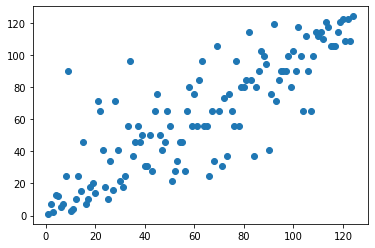

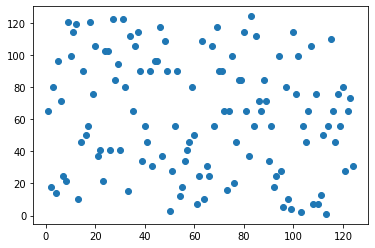

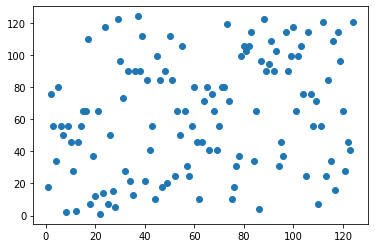

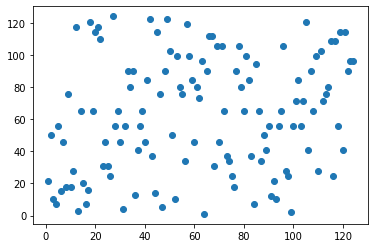

In [9]:
import matplotlib.pyplot as plt

plt.scatter(rank_confidences,rank_accs)
plt.show()

plt.scatter(rank_sensitivities,rank_accs)
plt.show()

plt.scatter(rank_robustnesses,rank_accs)
plt.show()

plt.scatter(rank_step_sims,rank_accs)
plt.show()

In [10]:
# for c in cells:
#     print(c.arch_cache)

Structure(4 nodes with |skip_connect~0|+|skip_connect~0|skip_connect~1|+|nor_conv_3x3~0|nor_conv_3x3~1|nor_conv_3x3~2|)


ValueError: I/O operation on closed file.

# Train a found model

In [16]:
trained_output = torch.load(os.path.join(xargs.save_dir, "output.pth"))
print(args)
args.save_dir = os.path.join(xargs.save_dir, "train")
print(args)

FileNotFoundError: [Errno 2] No such file or directory: './include_none-loop2-2_ep2-reset_classifier/train/output.pth'

In [32]:
print(config)

Configure(scheduler='cos', LR=0.025, eta_min=0.001, epochs=50, warmup=0, optim='SGD', decay=0.0005, momentum=0.9, nesterov=True, criterion='Softmax', batch_size=64, test_batch_size=512, class_num=10, xshape=(1, 3, 32, 32))


In [34]:
logger = prepare_logger(args)

# cifar_train_config_path = "./MY.config"
cifar_train_config_path = "../configs/nas-benchmark/CIFAR.config"
###
train_data, test_data, xshape, class_num = get_datasets(xargs.dataset, xargs.data_path, -1)
config = load_config(cifar_train_config_path, {"class_num": class_num, "xshape": xshape}, logger)

train_loader = torch.utils.data.DataLoader(
            train_data,
            batch_size=config.batch_size,
            shuffle=True,
            num_workers=xargs.workers,
            pin_memory=True,)

test_loader = torch.utils.data.DataLoader(
            test_data,
            batch_size=config.batch_size,
            shuffle=True,
            num_workers=xargs.workers,
            pin_memory=True,)

# search_loader, _, valid_loader = get_nas_search_loaders(train_data,
#                                                         valid_data,
#                                                         xargs.dataset,
#                                                         "../configs/nas-benchmark/",
#                                                         (config.batch_size, config.batch_size),
#                                                         xargs.workers)
logger.log("||||||| {:10s} ||||||| Train-Loader-Num={:}, Test-Loader-Num={:}, batch size={:}".format(
            xargs.dataset, len(train_loader), len(test_loader), config.batch_size))
logger.log("||||||| {:10s} ||||||| Config={:}".format(xargs.dataset, config))

search_space = get_search_spaces("cell", xargs.search_space_name)
model_config = dict2config(
    {
        "name": "RANDOM",
        "C": xargs.channel,
        "N": xargs.num_cells,
        "max_nodes": xargs.max_nodes,
        "num_classes": class_num,
        "space": search_space,
        "affine": False,
        "track_running_stats": True, # true for eval
    },
    None,
)
search_model = get_cell_based_tiny_net(model_config)

### load
# trained_output = torch.load(os.path.join(xargs.save_dir, "output.pth"))
# search_model.load_state_dict(trained_output['model'], strict=False)
best_archs = trained_output['best_archs']
i=0
for m in search_model.modules():
    if isinstance(m, SearchCell):
        m.arch_cache = best_archs[i]
        i += 1
for m in network.modules():
    if isinstance(m, SearchCell):
        print(m.arch_cache)
###

w_optimizer, w_scheduler, criterion = get_optim_scheduler(search_model.parameters(), config)

logger.log("w-optimizer : {:}".format(w_optimizer))
logger.log("w-scheduler : {:}".format(w_scheduler))
logger.log("criterion   : {:}".format(criterion))

network, criterion = torch.nn.DataParallel(search_model).cuda(), criterion.cuda()

last_info, model_base_path, model_best_path = (
    logger.path("info"),
    logger.path("model"),
    logger.path("best"),
)

start_epoch, valid_accuracies, genotypes = 0, {"best": -1}, {}

Main Function with logger : Logger(dir=include_none-loop2-2_ep2-reset_classifier/train-testset, use-tf=False, writer=None)
Arguments : -------------------------------
arch_nas_dataset : None
channel          : 16
config_path      : ./MY.config
data_path        : ../cifar.python
dataset          : cifar10
max_nodes        : 4
num_cells        : 5
print_freq       : 200
rand_seed        : 28723
save_dir         : ./include_none-loop2-2_ep2-reset_classifier/train-testset
search_space_name : nas-bench-201
select_num       : 100
track_running_stats : 0
workers          : 4
Python  Version  : 3.7.13 (default, Mar 29 2022, 02:18:16)  [GCC 7.5.0]
Pillow  Version  : 9.0.1
PyTorch Version  : 1.12.0
cuDNN   Version  : 8302
CUDA available   : True
CUDA GPU numbers : 2
CUDA_VISIBLE_DEVICES : None
Files already downloaded and verified
Files already downloaded and verified
../configs/nas-benchmark/CIFAR.config
Configure(scheduler='cos', eta_min=0.0, epochs=200, warmup=0, optim='SGD', LR=0.1, decay=0.

In [35]:
# def search_func_one_arch(xloader, network, criterion, scheduler, w_optimizer, epoch_str, print_freq, logger):
#     data_time, batch_time = AverageMeter(), AverageMeter()
#     base_losses, base_top1, base_top5 = AverageMeter(), AverageMeter(), AverageMeter()
#     network.train()
#     end = time.time()
#     for step, (base_inputs, base_targets, arch_inputs, arch_targets) in enumerate(
#         xloader
#     ):
#         scheduler.update(None, 1.0 * step / len(xloader))
#         base_targets = base_targets.cuda(non_blocking=True)
#         arch_targets = arch_targets.cuda(non_blocking=True)
#         # measure data loading time
#         data_time.update(time.time() - end)

#         w_optimizer.zero_grad()
#         _, logits = network(base_inputs)
#         base_loss = criterion(logits, base_targets)
#         base_loss.backward()
#         nn.utils.clip_grad_norm_(network.parameters(), 5)
#         w_optimizer.step()
#         # record
#         base_prec1, base_prec5 = obtain_accuracy(
#             logits.data, base_targets.data, topk=(1, 5)
#         )
#         base_losses.update(base_loss.item(), base_inputs.size(0))
#         base_top1.update(base_prec1.item(), base_inputs.size(0))
#         base_top5.update(base_prec5.item(), base_inputs.size(0))

#         # measure elapsed time
#         batch_time.update(time.time() - end)
#         end = time.time()

#         if step % print_freq == 0 or step + 1 == len(xloader):
#             Sstr = (
#                 "*SEARCH* "
#                 + time_string()
#                 + " [{:}][{:03d}/{:03d}]".format(epoch_str, step, len(xloader))
#             )
#             Tstr = "Time {batch_time.val:.2f} ({batch_time.avg:.2f}) Data {data_time.val:.2f} ({data_time.avg:.2f})".format(
#                 batch_time=batch_time, data_time=data_time
#             )
#             Wstr = "Base [Loss {loss.val:.3f} ({loss.avg:.3f})  Prec@1 {top1.val:.2f} ({top1.avg:.2f}) Prec@5 {top5.val:.2f} ({top5.avg:.2f})]".format(
#                 loss=base_losses, top1=base_top1, top5=base_top5
#             )
#             logger.log(Sstr + " " + Tstr + " " + Wstr)
#     return base_losses.avg, base_top1.avg, base_top5.avg

def train_func_one_arch(xloader, network, criterion, scheduler, w_optimizer, epoch_str, print_freq, logger):
    data_time, batch_time = AverageMeter(), AverageMeter()
    base_losses, base_top1, base_top5 = AverageMeter(), AverageMeter(), AverageMeter()
    network.train()
    end = time.time()
    for step, (base_inputs, base_targets) in enumerate(
        xloader
    ):
        scheduler.update(None, 1.0 * step / len(xloader))
        base_targets = base_targets.cuda(non_blocking=True)
        # measure data loading time
        data_time.update(time.time() - end)

        w_optimizer.zero_grad()
        _, logits = network(base_inputs)
        base_loss = criterion(logits, base_targets)
        base_loss.backward()
        nn.utils.clip_grad_norm_(network.parameters(), 5)
        w_optimizer.step()
        # record
        base_prec1, base_prec5 = obtain_accuracy(
            logits.data, base_targets.data, topk=(1, 5)
        )
        base_losses.update(base_loss.item(), base_inputs.size(0))
        base_top1.update(base_prec1.item(), base_inputs.size(0))
        base_top5.update(base_prec5.item(), base_inputs.size(0))

        # measure elapsed time
        batch_time.update(time.time() - end)
        end = time.time()

        if step % print_freq == 0 or step + 1 == len(xloader):
            Sstr = (
                "*SEARCH* "
                + time_string()
                + " [{:}][{:03d}/{:03d}]".format(epoch_str, step, len(xloader))
            )
            Tstr = "Time {batch_time.val:.2f} ({batch_time.avg:.2f}) Data {data_time.val:.2f} ({data_time.avg:.2f})".format(
                batch_time=batch_time, data_time=data_time
            )
            Wstr = "Base [Loss {loss.val:.3f} ({loss.avg:.3f})  Prec@1 {top1.val:.2f} ({top1.avg:.2f}) Prec@5 {top5.val:.2f} ({top5.avg:.2f})]".format(
                loss=base_losses, top1=base_top1, top5=base_top5
            )
            logger.log(Sstr + " " + Tstr + " " + Wstr)
    return base_losses.avg, base_top1.avg, base_top5.avg

def valid_func_one_arch(xloader, network, criterion):
    data_time, batch_time = AverageMeter(), AverageMeter()
    arch_losses, arch_top1, arch_top5 = AverageMeter(), AverageMeter(), AverageMeter()
    network.eval()
    end = time.time()
    with torch.no_grad():
        for step, (arch_inputs, arch_targets) in enumerate(xloader):
            arch_targets = arch_targets.cuda(non_blocking=True)
            # measure data loading time
            data_time.update(time.time() - end)
            # prediction

#             network.module.random_genotype_per_cell(True)
            _, logits = network(arch_inputs)
            arch_loss = criterion(logits, arch_targets)
            # record
            arch_prec1, arch_prec5 = obtain_accuracy(
                logits.data, arch_targets.data, topk=(1, 5)
            )
            arch_losses.update(arch_loss.item(), arch_inputs.size(0))
            arch_top1.update(arch_prec1.item(), arch_inputs.size(0))
            arch_top5.update(arch_prec5.item(), arch_inputs.size(0))
            # measure elapsed time
            batch_time.update(time.time() - end)
            end = time.time()
    return arch_losses.avg, arch_top1.avg, arch_top5.avg

In [36]:
start_time, search_time, epoch_time, total_epoch = (
    time.time(),
    AverageMeter(),
    AverageMeter(),
    config.epochs + config.warmup,
)
for epoch in range(0, total_epoch):
    w_scheduler.update(epoch, 0.0)
    need_time = "Time Left: {:}".format(
        convert_secs2time(epoch_time.val * (total_epoch - epoch), True)
    )
    epoch_str = "{:03d}-{:03d}".format(epoch, total_epoch)
    logger.log(
        "\n[Search the {:}-th epoch] {:}, LR={:}".format(
            epoch_str, need_time, min(w_scheduler.get_lr())
        )
    )

    # selected_arch = search_find_best(valid_loader, network, criterion, xargs.select_num)
    search_w_loss, search_w_top1, search_w_top5 = train_func_one_arch(
        train_loader,
        network,
        criterion,
        w_scheduler,
        w_optimizer,
        epoch_str,
        xargs.print_freq,
        logger,
    )
    search_time.update(time.time() - start_time)
    logger.log(
        "[{:}] searching : loss={:.2f}, accuracy@1={:.2f}%, accuracy@5={:.2f}%, time-cost={:.1f} s".format(
            epoch_str, search_w_loss, search_w_top1, search_w_top5, search_time.sum
        )
    )
    valid_a_loss, valid_a_top1, valid_a_top5 = valid_func_one_arch(
        test_loader, network, criterion
    )
    logger.log(
        "[{:}] evaluate  : loss={:.2f}, accuracy@1={:.2f}%, accuracy@5={:.2f}%".format(
            epoch_str, valid_a_loss, valid_a_top1, valid_a_top5
        )
    )
    
    # check the best accuracy
    valid_accuracies[epoch] = valid_a_top1
    if valid_a_top1 > valid_accuracies["best"]:
        valid_accuracies["best"] = valid_a_top1
        find_best = True
    else:
        find_best = False

    # save checkpoint
    save_path = save_checkpoint(
        {
            "epoch": epoch + 1,
            "args": deepcopy(xargs),
            "search_model": search_model.state_dict(),
            "w_optimizer": w_optimizer.state_dict(),
            "w_scheduler": w_scheduler.state_dict(),
            "genotypes": genotypes,
            "valid_accuracies": valid_accuracies,
        },
        model_base_path,
        logger,
    )
    last_info = save_checkpoint(
        {
            "epoch": epoch + 1,
            "args": deepcopy(args),
            "last_checkpoint": save_path,
        },
        logger.path("info"),
        logger,
    )
    if find_best:
        logger.log(
            "<<<--->>> The {:}-th epoch : find the highest validation accuracy : {:.2f}%.".format(
                epoch_str, valid_a_top1
            )
        )
        copy_checkpoint(model_base_path, model_best_path, logger)
    if api is not None:
        logger.log("{:}".format(api.query_by_arch(genotypes[epoch], "200")))
    # measure elapsed time
    epoch_time.update(time.time() - start_time)
    start_time = time.time()

logger.close()


[Search the 000-200-th epoch] Time Left: [00:00:00], LR=0.1
*SEARCH* [2022-11-02 05:54:53] [000-200][000/196] Time 0.34 (0.34) Data 0.16 (0.16) Base [Loss 2.326 (2.326)  Prec@1 8.59 (8.59) Prec@5 50.39 (50.39)]
*SEARCH* [2022-11-02 05:55:20] [000-200][195/196] Time 0.08 (0.14) Data 0.00 (0.00) Base [Loss 1.500 (1.703)  Prec@1 48.75 (35.99) Prec@5 93.75 (86.52)]
[000-200] searching : loss=1.70, accuracy@1=35.99%, accuracy@5=86.52%, time-cost=27.6 s
[000-200] evaluate  : loss=1.79, accuracy@1=37.38%, accuracy@5=86.82%
Find include_none-loop2-2_ep2-reset_classifier/train-testset/checkpoint/seed-28723-basic.pth exist, delete is at first before saving
save checkpoint into include_none-loop2-2_ep2-reset_classifier/train-testset/checkpoint/seed-28723-basic.pth
Find include_none-loop2-2_ep2-reset_classifier/train-testset/seed-28723-last-info.pth exist, delete is at first before saving
save checkpoint into include_none-loop2-2_ep2-reset_classifier/train-testset/seed-28723-last-info.pth
<<<--->

*SEARCH* [2022-11-02 05:58:21] [007-200][000/196] Time 0.42 (0.42) Data 0.25 (0.25) Base [Loss 0.633 (0.633)  Prec@1 77.34 (77.34) Prec@5 98.05 (98.05)]
*SEARCH* [2022-11-02 05:58:52] [007-200][195/196] Time 0.15 (0.16) Data 0.00 (0.00) Base [Loss 0.691 (0.662)  Prec@1 77.50 (77.12) Prec@5 97.50 (98.61)]
[007-200] searching : loss=0.66, accuracy@1=77.12%, accuracy@5=98.61%, time-cost=216.9 s
[007-200] evaluate  : loss=0.91, accuracy@1=70.54%, accuracy@5=97.43%
Find include_none-loop2-2_ep2-reset_classifier/train-testset/checkpoint/seed-28723-basic.pth exist, delete is at first before saving
save checkpoint into include_none-loop2-2_ep2-reset_classifier/train-testset/checkpoint/seed-28723-basic.pth
Find include_none-loop2-2_ep2-reset_classifier/train-testset/seed-28723-last-info.pth exist, delete is at first before saving
save checkpoint into include_none-loop2-2_ep2-reset_classifier/train-testset/seed-28723-last-info.pth
<<<--->>> The 007-200-th epoch : find the highest validation accu

*SEARCH* [2022-11-02 06:01:30] [014-200][000/196] Time 0.27 (0.27) Data 0.16 (0.16) Base [Loss 0.454 (0.454)  Prec@1 83.59 (83.59) Prec@5 99.61 (99.61)]
*SEARCH* [2022-11-02 06:01:56] [014-200][195/196] Time 0.08 (0.14) Data 0.00 (0.00) Base [Loss 0.561 (0.536)  Prec@1 78.75 (81.50) Prec@5 100.00 (99.15)]
[014-200] searching : loss=0.54, accuracy@1=81.50%, accuracy@5=99.15%, time-cost=375.9 s
[014-200] evaluate  : loss=1.13, accuracy@1=64.98%, accuracy@5=97.24%
Find include_none-loop2-2_ep2-reset_classifier/train-testset/checkpoint/seed-28723-basic.pth exist, delete is at first before saving
save checkpoint into include_none-loop2-2_ep2-reset_classifier/train-testset/checkpoint/seed-28723-basic.pth
Find include_none-loop2-2_ep2-reset_classifier/train-testset/seed-28723-last-info.pth exist, delete is at first before saving
save checkpoint into include_none-loop2-2_ep2-reset_classifier/train-testset/seed-28723-last-info.pth

[Search the 015-200-th epoch] Time Left: [01:31:25], LR=0.09861

[021-200] evaluate  : loss=0.86, accuracy@1=71.79%, accuracy@5=97.95%
Find include_none-loop2-2_ep2-reset_classifier/train-testset/checkpoint/seed-28723-basic.pth exist, delete is at first before saving
save checkpoint into include_none-loop2-2_ep2-reset_classifier/train-testset/checkpoint/seed-28723-basic.pth
Find include_none-loop2-2_ep2-reset_classifier/train-testset/seed-28723-last-info.pth exist, delete is at first before saving
save checkpoint into include_none-loop2-2_ep2-reset_classifier/train-testset/seed-28723-last-info.pth

[Search the 022-200-th epoch] Time Left: [01:17:52], LR=0.09704403844771128
*SEARCH* [2022-11-02 06:05:18] [022-200][000/196] Time 0.32 (0.32) Data 0.14 (0.14) Base [Loss 0.505 (0.505)  Prec@1 81.64 (81.64) Prec@5 100.00 (100.00)]
*SEARCH* [2022-11-02 06:05:48] [022-200][195/196] Time 0.13 (0.15) Data 0.00 (0.00) Base [Loss 0.735 (0.476)  Prec@1 73.75 (83.47) Prec@5 98.75 (99.24)]
[022-200] searching : loss=0.48, accuracy@1=83.47%, accuracy@5=99.24%, time

*SEARCH* [2022-11-02 06:08:52] [030-200][000/196] Time 0.29 (0.29) Data 0.16 (0.16) Base [Loss 0.361 (0.361)  Prec@1 87.50 (87.50) Prec@5 100.00 (100.00)]
*SEARCH* [2022-11-02 06:09:12] [030-200][195/196] Time 0.08 (0.10) Data 0.00 (0.00) Base [Loss 0.396 (0.435)  Prec@1 87.50 (84.99) Prec@5 100.00 (99.37)]
[030-200] searching : loss=0.43, accuracy@1=84.99%, accuracy@5=99.37%, time-cost=761.9 s
[030-200] evaluate  : loss=1.10, accuracy@1=68.08%, accuracy@5=98.25%
Find include_none-loop2-2_ep2-reset_classifier/train-testset/checkpoint/seed-28723-basic.pth exist, delete is at first before saving
save checkpoint into include_none-loop2-2_ep2-reset_classifier/train-testset/checkpoint/seed-28723-basic.pth
Find include_none-loop2-2_ep2-reset_classifier/train-testset/seed-28723-last-info.pth exist, delete is at first before saving
save checkpoint into include_none-loop2-2_ep2-reset_classifier/train-testset/seed-28723-last-info.pth

[Search the 031-200-th epoch] Time Left: [01:08:00], LR=0.094

*SEARCH* [2022-11-02 06:12:36] [038-200][000/196] Time 0.30 (0.30) Data 0.18 (0.18) Base [Loss 0.331 (0.331)  Prec@1 87.89 (87.89) Prec@5 99.61 (99.61)]
*SEARCH* [2022-11-02 06:12:59] [038-200][195/196] Time 0.08 (0.12) Data 0.00 (0.00) Base [Loss 0.413 (0.412)  Prec@1 85.00 (85.85) Prec@5 100.00 (99.48)]
[038-200] searching : loss=0.41, accuracy@1=85.85%, accuracy@5=99.48%, time-cost=962.1 s
[038-200] evaluate  : loss=0.81, accuracy@1=74.84%, accuracy@5=98.66%
Find include_none-loop2-2_ep2-reset_classifier/train-testset/checkpoint/seed-28723-basic.pth exist, delete is at first before saving
save checkpoint into include_none-loop2-2_ep2-reset_classifier/train-testset/checkpoint/seed-28723-basic.pth
Find include_none-loop2-2_ep2-reset_classifier/train-testset/seed-28723-last-info.pth exist, delete is at first before saving
save checkpoint into include_none-loop2-2_ep2-reset_classifier/train-testset/seed-28723-last-info.pth

[Search the 039-200-th epoch] Time Left: [01:11:27], LR=0.09090

*SEARCH* [2022-11-02 06:16:33] [046-200][000/196] Time 0.42 (0.42) Data 0.25 (0.25) Base [Loss 0.363 (0.363)  Prec@1 88.28 (88.28) Prec@5 99.61 (99.61)]
*SEARCH* [2022-11-02 06:17:03] [046-200][195/196] Time 0.14 (0.16) Data 0.00 (0.00) Base [Loss 0.491 (0.393)  Prec@1 82.50 (86.52) Prec@5 98.75 (99.51)]
[046-200] searching : loss=0.39, accuracy@1=86.52%, accuracy@5=99.51%, time-cost=1179.1 s
[046-200] evaluate  : loss=1.15, accuracy@1=68.98%, accuracy@5=98.18%
Find include_none-loop2-2_ep2-reset_classifier/train-testset/checkpoint/seed-28723-basic.pth exist, delete is at first before saving
save checkpoint into include_none-loop2-2_ep2-reset_classifier/train-testset/checkpoint/seed-28723-basic.pth
Find include_none-loop2-2_ep2-reset_classifier/train-testset/seed-28723-last-info.pth exist, delete is at first before saving
save checkpoint into include_none-loop2-2_ep2-reset_classifier/train-testset/seed-28723-last-info.pth

[Search the 047-200-th epoch] Time Left: [01:24:47], LR=0.08698

*SEARCH* [2022-11-02 06:20:56] [054-200][195/196] Time 0.07 (0.15) Data 0.00 (0.00) Base [Loss 0.291 (0.370)  Prec@1 90.00 (87.36) Prec@5 98.75 (99.56)]
[054-200] searching : loss=0.37, accuracy@1=87.36%, accuracy@5=99.56%, time-cost=1385.8 s
[054-200] evaluate  : loss=0.77, accuracy@1=77.10%, accuracy@5=98.76%
Find include_none-loop2-2_ep2-reset_classifier/train-testset/checkpoint/seed-28723-basic.pth exist, delete is at first before saving
save checkpoint into include_none-loop2-2_ep2-reset_classifier/train-testset/checkpoint/seed-28723-basic.pth
Find include_none-loop2-2_ep2-reset_classifier/train-testset/seed-28723-last-info.pth exist, delete is at first before saving
save checkpoint into include_none-loop2-2_ep2-reset_classifier/train-testset/seed-28723-last-info.pth

[Search the 055-200-th epoch] Time Left: [01:18:52], LR=0.08247240241650919
*SEARCH* [2022-11-02 06:21:01] [055-200][000/196] Time 0.36 (0.36) Data 0.25 (0.25) Base [Loss 0.496 (0.496)  Prec@1 82.03 (82.03) Prec@5 98

*SEARCH* [2022-11-02 06:24:08] [062-200][000/196] Time 0.32 (0.32) Data 0.15 (0.15) Base [Loss 0.271 (0.271)  Prec@1 89.45 (89.45) Prec@5 100.00 (100.00)]
*SEARCH* [2022-11-02 06:24:37] [062-200][195/196] Time 0.13 (0.15) Data 0.00 (0.00) Base [Loss 0.284 (0.357)  Prec@1 88.75 (87.77) Prec@5 100.00 (99.61)]
[062-200] searching : loss=0.36, accuracy@1=87.77%, accuracy@5=99.61%, time-cost=1579.6 s
[062-200] evaluate  : loss=0.51, accuracy@1=82.55%, accuracy@5=99.36%
Find include_none-loop2-2_ep2-reset_classifier/train-testset/checkpoint/seed-28723-basic.pth exist, delete is at first before saving
save checkpoint into include_none-loop2-2_ep2-reset_classifier/train-testset/checkpoint/seed-28723-basic.pth
Find include_none-loop2-2_ep2-reset_classifier/train-testset/seed-28723-last-info.pth exist, delete is at first before saving
save checkpoint into include_none-loop2-2_ep2-reset_classifier/train-testset/seed-28723-last-info.pth
<<<--->>> The 062-200-th epoch : find the highest validation 

*SEARCH* [2022-11-02 06:28:05] [070-200][000/196] Time 0.32 (0.32) Data 0.14 (0.14) Base [Loss 0.348 (0.348)  Prec@1 85.55 (85.55) Prec@5 100.00 (100.00)]
*SEARCH* [2022-11-02 06:28:25] [070-200][195/196] Time 0.08 (0.10) Data 0.00 (0.00) Base [Loss 0.340 (0.341)  Prec@1 87.50 (88.22) Prec@5 100.00 (99.65)]
[070-200] searching : loss=0.34, accuracy@1=88.22%, accuracy@5=99.65%, time-cost=1781.7 s
[070-200] evaluate  : loss=0.55, accuracy@1=81.40%, accuracy@5=98.93%
Find include_none-loop2-2_ep2-reset_classifier/train-testset/checkpoint/seed-28723-basic.pth exist, delete is at first before saving
save checkpoint into include_none-loop2-2_ep2-reset_classifier/train-testset/checkpoint/seed-28723-basic.pth
Find include_none-loop2-2_ep2-reset_classifier/train-testset/seed-28723-last-info.pth exist, delete is at first before saving
save checkpoint into include_none-loop2-2_ep2-reset_classifier/train-testset/seed-28723-last-info.pth

[Search the 071-200-th epoch] Time Left: [00:50:29], LR=0.07

[077-200] evaluate  : loss=0.71, accuracy@1=77.85%, accuracy@5=98.92%
Find include_none-loop2-2_ep2-reset_classifier/train-testset/checkpoint/seed-28723-basic.pth exist, delete is at first before saving
save checkpoint into include_none-loop2-2_ep2-reset_classifier/train-testset/checkpoint/seed-28723-basic.pth
Find include_none-loop2-2_ep2-reset_classifier/train-testset/seed-28723-last-info.pth exist, delete is at first before saving
save checkpoint into include_none-loop2-2_ep2-reset_classifier/train-testset/seed-28723-last-info.pth

[Search the 078-200-th epoch] Time Left: [00:47:22], LR=0.06693689601226459
*SEARCH* [2022-11-02 06:31:38] [078-200][000/196] Time 0.35 (0.35) Data 0.24 (0.24) Base [Loss 0.371 (0.371)  Prec@1 90.23 (90.23) Prec@5 99.61 (99.61)]
*SEARCH* [2022-11-02 06:32:01] [078-200][195/196] Time 0.13 (0.12) Data 0.00 (0.00) Base [Loss 0.262 (0.320)  Prec@1 93.75 (88.99) Prec@5 100.00 (99.71)]
[078-200] searching : loss=0.32, accuracy@1=88.99%, accuracy@5=99.71%, time-

*SEARCH* [2022-11-02 06:35:20] [086-200][000/196] Time 0.39 (0.39) Data 0.15 (0.15) Base [Loss 0.285 (0.285)  Prec@1 89.84 (89.84) Prec@5 99.61 (99.61)]
*SEARCH* [2022-11-02 06:35:40] [086-200][195/196] Time 0.08 (0.11) Data 0.00 (0.00) Base [Loss 0.360 (0.304)  Prec@1 86.25 (89.56) Prec@5 100.00 (99.75)]
[086-200] searching : loss=0.30, accuracy@1=89.56%, accuracy@5=99.75%, time-cost=2165.1 s
[086-200] evaluate  : loss=0.75, accuracy@1=77.49%, accuracy@5=98.74%
Find include_none-loop2-2_ep2-reset_classifier/train-testset/checkpoint/seed-28723-basic.pth exist, delete is at first before saving
save checkpoint into include_none-loop2-2_ep2-reset_classifier/train-testset/checkpoint/seed-28723-basic.pth
Find include_none-loop2-2_ep2-reset_classifier/train-testset/seed-28723-last-info.pth exist, delete is at first before saving
save checkpoint into include_none-loop2-2_ep2-reset_classifier/train-testset/seed-28723-last-info.pth

[Search the 087-200-th epoch] Time Left: [00:44:16], LR=0.0601

*SEARCH* [2022-11-02 06:39:24] [094-200][195/196] Time 0.13 (0.15) Data 0.00 (0.00) Base [Loss 0.262 (0.289)  Prec@1 91.25 (89.97) Prec@5 100.00 (99.74)]
[094-200] searching : loss=0.29, accuracy@1=89.97%, accuracy@5=99.74%, time-cost=2360.9 s
[094-200] evaluate  : loss=0.66, accuracy@1=79.23%, accuracy@5=98.59%
Find include_none-loop2-2_ep2-reset_classifier/train-testset/checkpoint/seed-28723-basic.pth exist, delete is at first before saving
save checkpoint into include_none-loop2-2_ep2-reset_classifier/train-testset/checkpoint/seed-28723-basic.pth
Find include_none-loop2-2_ep2-reset_classifier/train-testset/seed-28723-last-info.pth exist, delete is at first before saving
save checkpoint into include_none-loop2-2_ep2-reset_classifier/train-testset/seed-28723-last-info.pth

[Search the 095-200-th epoch] Time Left: [00:57:44], LR=0.05392295478639225
*SEARCH* [2022-11-02 06:39:27] [095-200][000/196] Time 0.26 (0.26) Data 0.15 (0.15) Base [Loss 0.324 (0.324)  Prec@1 89.06 (89.06) Prec@5 1

*SEARCH* [2022-11-02 06:42:44] [102-200][000/196] Time 0.36 (0.36) Data 0.14 (0.14) Base [Loss 0.196 (0.196)  Prec@1 92.19 (92.19) Prec@5 100.00 (100.00)]
*SEARCH* [2022-11-02 06:43:10] [102-200][195/196] Time 0.13 (0.13) Data 0.00 (0.00) Base [Loss 0.253 (0.269)  Prec@1 92.50 (90.63) Prec@5 100.00 (99.79)]
[102-200] searching : loss=0.27, accuracy@1=90.63%, accuracy@5=99.79%, time-cost=2559.5 s
[102-200] evaluate  : loss=0.45, accuracy@1=85.43%, accuracy@5=99.35%
Find include_none-loop2-2_ep2-reset_classifier/train-testset/checkpoint/seed-28723-basic.pth exist, delete is at first before saving
save checkpoint into include_none-loop2-2_ep2-reset_classifier/train-testset/checkpoint/seed-28723-basic.pth
Find include_none-loop2-2_ep2-reset_classifier/train-testset/seed-28723-last-info.pth exist, delete is at first before saving
save checkpoint into include_none-loop2-2_ep2-reset_classifier/train-testset/seed-28723-last-info.pth
<<<--->>> The 102-200-th epoch : find the highest validation 

*SEARCH* [2022-11-02 06:46:09] [110-200][000/196] Time 0.28 (0.28) Data 0.16 (0.16) Base [Loss 0.242 (0.242)  Prec@1 90.23 (90.23) Prec@5 99.61 (99.61)]
*SEARCH* [2022-11-02 06:46:34] [110-200][195/196] Time 0.13 (0.13) Data 0.00 (0.00) Base [Loss 0.398 (0.254)  Prec@1 86.25 (91.12) Prec@5 98.75 (99.82)]
[110-200] searching : loss=0.25, accuracy@1=91.12%, accuracy@5=99.82%, time-cost=2734.6 s
[110-200] evaluate  : loss=0.48, accuracy@1=84.26%, accuracy@5=99.39%
Find include_none-loop2-2_ep2-reset_classifier/train-testset/checkpoint/seed-28723-basic.pth exist, delete is at first before saving
save checkpoint into include_none-loop2-2_ep2-reset_classifier/train-testset/checkpoint/seed-28723-basic.pth
Find include_none-loop2-2_ep2-reset_classifier/train-testset/seed-28723-last-info.pth exist, delete is at first before saving
save checkpoint into include_none-loop2-2_ep2-reset_classifier/train-testset/seed-28723-last-info.pth

[Search the 111-200-th epoch] Time Left: [00:40:52], LR=0.04140

[117-200] evaluate  : loss=0.50, accuracy@1=83.95%, accuracy@5=99.32%
Find include_none-loop2-2_ep2-reset_classifier/train-testset/checkpoint/seed-28723-basic.pth exist, delete is at first before saving
save checkpoint into include_none-loop2-2_ep2-reset_classifier/train-testset/checkpoint/seed-28723-basic.pth
Find include_none-loop2-2_ep2-reset_classifier/train-testset/seed-28723-last-info.pth exist, delete is at first before saving
save checkpoint into include_none-loop2-2_ep2-reset_classifier/train-testset/seed-28723-last-info.pth

[Search the 118-200-th epoch] Time Left: [00:31:19], LR=0.036050444698038545
*SEARCH* [2022-11-02 06:49:51] [118-200][000/196] Time 0.26 (0.26) Data 0.14 (0.14) Base [Loss 0.225 (0.225)  Prec@1 92.58 (92.58) Prec@5 100.00 (100.00)]
*SEARCH* [2022-11-02 06:50:15] [118-200][195/196] Time 0.15 (0.13) Data 0.00 (0.00) Base [Loss 0.302 (0.230)  Prec@1 92.50 (91.98) Prec@5 98.75 (99.85)]
[118-200] searching : loss=0.23, accuracy@1=91.98%, accuracy@5=99.85%, tim

*SEARCH* [2022-11-02 06:53:39] [126-200][000/196] Time 0.29 (0.29) Data 0.17 (0.17) Base [Loss 0.203 (0.203)  Prec@1 93.36 (93.36) Prec@5 100.00 (100.00)]
*SEARCH* [2022-11-02 06:54:01] [126-200][195/196] Time 0.15 (0.11) Data 0.00 (0.00) Base [Loss 0.329 (0.204)  Prec@1 91.25 (93.05) Prec@5 100.00 (99.88)]
[126-200] searching : loss=0.20, accuracy@1=93.05%, accuracy@5=99.88%, time-cost=3129.8 s
[126-200] evaluate  : loss=0.46, accuracy@1=86.10%, accuracy@5=99.33%
Find include_none-loop2-2_ep2-reset_classifier/train-testset/checkpoint/seed-28723-basic.pth exist, delete is at first before saving
save checkpoint into include_none-loop2-2_ep2-reset_classifier/train-testset/checkpoint/seed-28723-basic.pth
Find include_none-loop2-2_ep2-reset_classifier/train-testset/seed-28723-last-info.pth exist, delete is at first before saving
save checkpoint into include_none-loop2-2_ep2-reset_classifier/train-testset/seed-28723-last-info.pth

[Search the 127-200-th epoch] Time Left: [00:30:24], LR=0.02

*SEARCH* [2022-11-02 06:56:49] [133-200][000/196] Time 0.40 (0.40) Data 0.23 (0.23) Base [Loss 0.106 (0.106)  Prec@1 97.66 (97.66) Prec@5 100.00 (100.00)]
*SEARCH* [2022-11-02 06:57:18] [133-200][195/196] Time 0.07 (0.15) Data 0.00 (0.00) Base [Loss 0.240 (0.185)  Prec@1 92.50 (93.53) Prec@5 100.00 (99.91)]
[133-200] searching : loss=0.19, accuracy@1=93.53%, accuracy@5=99.91%, time-cost=3306.9 s
[133-200] evaluate  : loss=0.44, accuracy@1=86.31%, accuracy@5=99.47%
Find include_none-loop2-2_ep2-reset_classifier/train-testset/checkpoint/seed-28723-basic.pth exist, delete is at first before saving
save checkpoint into include_none-loop2-2_ep2-reset_classifier/train-testset/checkpoint/seed-28723-basic.pth
Find include_none-loop2-2_ep2-reset_classifier/train-testset/seed-28723-last-info.pth exist, delete is at first before saving
save checkpoint into include_none-loop2-2_ep2-reset_classifier/train-testset/seed-28723-last-info.pth

[Search the 134-200-th epoch] Time Left: [00:36:01], LR=0.02

*SEARCH* [2022-11-02 07:00:30] [141-200][000/196] Time 0.37 (0.37) Data 0.15 (0.15) Base [Loss 0.197 (0.197)  Prec@1 92.58 (92.58) Prec@5 100.00 (100.00)]
*SEARCH* [2022-11-02 07:00:57] [141-200][195/196] Time 0.08 (0.14) Data 0.00 (0.00) Base [Loss 0.237 (0.159)  Prec@1 91.25 (94.49) Prec@5 100.00 (99.92)]
[141-200] searching : loss=0.16, accuracy@1=94.49%, accuracy@5=99.92%, time-cost=3501.4 s
[141-200] evaluate  : loss=0.45, accuracy@1=86.69%, accuracy@5=99.35%
Find include_none-loop2-2_ep2-reset_classifier/train-testset/checkpoint/seed-28723-basic.pth exist, delete is at first before saving
save checkpoint into include_none-loop2-2_ep2-reset_classifier/train-testset/checkpoint/seed-28723-basic.pth
Find include_none-loop2-2_ep2-reset_classifier/train-testset/seed-28723-last-info.pth exist, delete is at first before saving
save checkpoint into include_none-loop2-2_ep2-reset_classifier/train-testset/seed-28723-last-info.pth

[Search the 142-200-th epoch] Time Left: [00:28:42], LR=0.01

*SEARCH* [2022-11-02 07:04:36] [149-200][195/196] Time 0.08 (0.10) Data 0.00 (0.00) Base [Loss 0.213 (0.128)  Prec@1 91.25 (95.59) Prec@5 100.00 (99.96)]
[149-200] searching : loss=0.13, accuracy@1=95.59%, accuracy@5=99.96%, time-cost=3692.9 s
[149-200] evaluate  : loss=0.36, accuracy@1=89.10%, accuracy@5=99.54%
Find include_none-loop2-2_ep2-reset_classifier/train-testset/checkpoint/seed-28723-basic.pth exist, delete is at first before saving
save checkpoint into include_none-loop2-2_ep2-reset_classifier/train-testset/checkpoint/seed-28723-basic.pth
Find include_none-loop2-2_ep2-reset_classifier/train-testset/seed-28723-last-info.pth exist, delete is at first before saving
save checkpoint into include_none-loop2-2_ep2-reset_classifier/train-testset/seed-28723-last-info.pth
<<<--->>> The 149-200-th epoch : find the highest validation accuracy : 89.10%.
Find include_none-loop2-2_ep2-reset_classifier/train-testset/checkpoint/seed-28723-best.pth exist, delete is at first before saving
copy

*SEARCH* [2022-11-02 07:07:56] [157-200][000/196] Time 0.35 (0.35) Data 0.19 (0.19) Base [Loss 0.101 (0.101)  Prec@1 96.88 (96.88) Prec@5 100.00 (100.00)]
*SEARCH* [2022-11-02 07:08:17] [157-200][195/196] Time 0.08 (0.11) Data 0.00 (0.00) Base [Loss 0.107 (0.095)  Prec@1 95.00 (96.84) Prec@5 100.00 (99.98)]
[157-200] searching : loss=0.10, accuracy@1=96.84%, accuracy@5=99.98%, time-cost=3885.2 s
[157-200] evaluate  : loss=0.35, accuracy@1=89.64%, accuracy@5=99.63%
Find include_none-loop2-2_ep2-reset_classifier/train-testset/checkpoint/seed-28723-basic.pth exist, delete is at first before saving
save checkpoint into include_none-loop2-2_ep2-reset_classifier/train-testset/checkpoint/seed-28723-basic.pth
Find include_none-loop2-2_ep2-reset_classifier/train-testset/seed-28723-last-info.pth exist, delete is at first before saving
save checkpoint into include_none-loop2-2_ep2-reset_classifier/train-testset/seed-28723-last-info.pth

[Search the 158-200-th epoch] Time Left: [00:17:20], LR=0.01

*SEARCH* [2022-11-02 07:11:33] [165-200][000/196] Time 0.27 (0.27) Data 0.15 (0.15) Base [Loss 0.049 (0.049)  Prec@1 98.44 (98.44) Prec@5 100.00 (100.00)]
*SEARCH* [2022-11-02 07:11:58] [165-200][195/196] Time 0.13 (0.13) Data 0.00 (0.00) Base [Loss 0.123 (0.071)  Prec@1 97.50 (97.60) Prec@5 100.00 (99.99)]
[165-200] searching : loss=0.07, accuracy@1=97.60%, accuracy@5=99.99%, time-cost=4080.0 s
[165-200] evaluate  : loss=0.33, accuracy@1=90.63%, accuracy@5=99.68%
Find include_none-loop2-2_ep2-reset_classifier/train-testset/checkpoint/seed-28723-basic.pth exist, delete is at first before saving
save checkpoint into include_none-loop2-2_ep2-reset_classifier/train-testset/checkpoint/seed-28723-basic.pth
Find include_none-loop2-2_ep2-reset_classifier/train-testset/seed-28723-last-info.pth exist, delete is at first before saving
save checkpoint into include_none-loop2-2_ep2-reset_classifier/train-testset/seed-28723-last-info.pth
<<<--->>> The 165-200-th epoch : find the highest validation 

[172-200] evaluate  : loss=0.35, accuracy@1=90.69%, accuracy@5=99.64%
Find include_none-loop2-2_ep2-reset_classifier/train-testset/checkpoint/seed-28723-basic.pth exist, delete is at first before saving
save checkpoint into include_none-loop2-2_ep2-reset_classifier/train-testset/checkpoint/seed-28723-basic.pth
Find include_none-loop2-2_ep2-reset_classifier/train-testset/seed-28723-last-info.pth exist, delete is at first before saving
save checkpoint into include_none-loop2-2_ep2-reset_classifier/train-testset/seed-28723-last-info.pth

[Search the 173-200-th epoch] Time Left: [00:14:34], LR=0.004429836168227746
*SEARCH* [2022-11-02 07:15:01] [173-200][000/196] Time 0.35 (0.35) Data 0.23 (0.23) Base [Loss 0.032 (0.032)  Prec@1 98.44 (98.44) Prec@5 100.00 (100.00)]
*SEARCH* [2022-11-02 07:15:21] [173-200][195/196] Time 0.09 (0.10) Data 0.00 (0.00) Base [Loss 0.055 (0.045)  Prec@1 98.75 (98.52) Prec@5 100.00 (100.00)]
[173-200] searching : loss=0.04, accuracy@1=98.52%, accuracy@5=100.00%, 

*SEARCH* [2022-11-02 07:17:33] [179-200][000/196] Time 0.35 (0.35) Data 0.17 (0.17) Base [Loss 0.041 (0.041)  Prec@1 98.83 (98.83) Prec@5 100.00 (100.00)]
*SEARCH* [2022-11-02 07:18:03] [179-200][195/196] Time 0.13 (0.15) Data 0.00 (0.00) Base [Loss 0.062 (0.031)  Prec@1 97.50 (99.05) Prec@5 100.00 (100.00)]
[179-200] searching : loss=0.03, accuracy@1=99.05%, accuracy@5=100.00%, time-cost=4399.1 s
[179-200] evaluate  : loss=0.33, accuracy@1=91.40%, accuracy@5=99.70%
Find include_none-loop2-2_ep2-reset_classifier/train-testset/checkpoint/seed-28723-basic.pth exist, delete is at first before saving
save checkpoint into include_none-loop2-2_ep2-reset_classifier/train-testset/checkpoint/seed-28723-basic.pth
Find include_none-loop2-2_ep2-reset_classifier/train-testset/seed-28723-last-info.pth exist, delete is at first before saving
save checkpoint into include_none-loop2-2_ep2-reset_classifier/train-testset/seed-28723-last-info.pth

[Search the 180-200-th epoch] Time Left: [00:11:24], LR=0.

*SEARCH* [2022-11-02 07:21:57] [187-200][195/196] Time 0.14 (0.15) Data 0.00 (0.00) Base [Loss 0.064 (0.020)  Prec@1 97.50 (99.45) Prec@5 100.00 (100.00)]
[187-200] searching : loss=0.02, accuracy@1=99.45%, accuracy@5=100.00%, time-cost=4607.0 s
[187-200] evaluate  : loss=0.33, accuracy@1=91.82%, accuracy@5=99.70%
Find include_none-loop2-2_ep2-reset_classifier/train-testset/checkpoint/seed-28723-basic.pth exist, delete is at first before saving
save checkpoint into include_none-loop2-2_ep2-reset_classifier/train-testset/checkpoint/seed-28723-basic.pth
Find include_none-loop2-2_ep2-reset_classifier/train-testset/seed-28723-last-info.pth exist, delete is at first before saving
save checkpoint into include_none-loop2-2_ep2-reset_classifier/train-testset/seed-28723-last-info.pth
<<<--->>> The 187-200-th epoch : find the highest validation accuracy : 91.82%.
Find include_none-loop2-2_ep2-reset_classifier/train-testset/checkpoint/seed-28723-best.pth exist, delete is at first before saving
co

*SEARCH* [2022-11-02 07:24:49] [194-200][000/196] Time 0.32 (0.32) Data 0.14 (0.14) Base [Loss 0.020 (0.020)  Prec@1 99.61 (99.61) Prec@5 100.00 (100.00)]
*SEARCH* [2022-11-02 07:25:15] [194-200][195/196] Time 0.08 (0.13) Data 0.00 (0.00) Base [Loss 0.023 (0.015)  Prec@1 98.75 (99.59) Prec@5 100.00 (100.00)]
[194-200] searching : loss=0.02, accuracy@1=99.59%, accuracy@5=100.00%, time-cost=4784.5 s
[194-200] evaluate  : loss=0.33, accuracy@1=91.71%, accuracy@5=99.69%
Find include_none-loop2-2_ep2-reset_classifier/train-testset/checkpoint/seed-28723-basic.pth exist, delete is at first before saving
save checkpoint into include_none-loop2-2_ep2-reset_classifier/train-testset/checkpoint/seed-28723-basic.pth
Find include_none-loop2-2_ep2-reset_classifier/train-testset/seed-28723-last-info.pth exist, delete is at first before saving
save checkpoint into include_none-loop2-2_ep2-reset_classifier/train-testset/seed-28723-last-info.pth

[Search the 195-200-th epoch] Time Left: [00:02:30], LR=0.

In [ ]:
best_archs